<a href="https://colab.research.google.com/github/AryaPratamaPutra-10/Analyst-Uang/blob/main/Selamat_Datang_di_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryapratamaputra10","key":"95340623c73554e9a82c2177872296e0"}'}

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!kaggle datasets download
import os
import zipfile

# Pastikan Kaggle API Key sudah terkonfigurasi
!mkdir -p ~/.kaggle
!cp /path/to/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tentukan dataset Kaggle dan tujuan
dataset_name = "yunhann/indonesian-rupiah-emission-2022-real-and-fake"
output_dir = "/content/rupiah-real-fake-dataset/dataset"

# dataset_path = "/content/rupiah-real-fake-dataset/dataset"


# Unduh dataset
!kaggle datasets download -d {dataset_name} -p /content

# Cari file ZIP yang sesuai
zip_file = f"/content/{dataset_name.split('/')[-1]}.zip"

# Ekstrak file ZIP ke folder tujuan
if os.path.exists(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Dataset berhasil diekstrak ke: {output_dir}")

    # Hapus file ZIP untuk menghemat ruang
    os.remove(zip_file)
else:
    print("File ZIP tidak ditemukan!")


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 63, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1569, in dataset_download_cli
    owner_slug, dataset_slug, _ = self.split_dataset_string(dataset)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 4162, in split_dataset_string
    if '/' in dataset:
       ^^^^^^^^^^^^^^
TypeError: argument of type 'NoneType' is not iterable
cp: cannot stat '/path/to/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/yunhann/indonesian-rupiah-emission-2022-real-and-fake
L

Labelling Data

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "/content/rupiah-real-fake-dataset/dataset/dataset"




# Buat objek ImageDataGenerator untuk preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel (0-1)
    validation_split=0.1  # 10% data untuk validasi
)


train_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset/dataset",  # Arahkan langsung ke "dataset"
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset/dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)




train_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset/dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

label_mapping = {
    "uang 100 asli": 0,
    "uang 100 palsu": 1,
    "uang 50 asli": 2,
    "uang 50 palsu": 3
}


print("Classes:", train_generator.class_indices)


Found 198 images belonging to 4 classes.
Found 22 images belonging to 4 classes.
Found 220 images belonging to 4 classes.
Classes: {'uang100asli': 0, 'uang100palsu': 1, 'uang50asli': 2, 'uang50palsu': 3}


In [15]:
import os
import shutil
import random

# Path asal dataset
dataset_path = "/content/rupiah-real-fake-dataset/dataset/dataset"


# Path tujuan setelah dipisah
output_path = "data"
train_path = os.path.join(output_path, "train")
val_path = os.path.join(output_path, "val")

# Pastikan direktori tujuan ada
for path in [train_path, val_path]:
    for category in ["asli", "palsu"]:
        os.makedirs(os.path.join(path, category), exist_ok=True)

# Mapping folder ke kategori (asli/palsu)
category_map = {
    "uang100asli": "asli",
    "uang50asli": "asli",
    "uang100palsu": "palsu",
    "uang50palsu": "palsu"
}

# Fungsi untuk membagi dataset
def split_data(source_folder, dest_train, dest_val, split_ratio=0.2):
    images = os.listdir(source_folder)
    random.shuffle(images)  # Acak urutan gambar

    # Hitung jumlah untuk validasi
    split_idx = int(len(images) * split_ratio)

    for i, img in enumerate(images):
        src = os.path.join(source_folder, img)

        # Tentukan folder tujuan (train atau val)
        if i < split_idx:
            dest = os.path.join(dest_val, img)
        else:
            dest = os.path.join(dest_train, img)

        shutil.copy2(src, dest)  # Copy file

# Proses pemisahan dataset
for folder, category in category_map.items():
    source_folder = os.path.join(dataset_path, folder)

    train_dest = os.path.join(train_path, category)
    val_dest = os.path.join(val_path, category)

    split_data(source_folder, train_dest, val_dest)

print("✅ Dataset berhasil dipisahkan!")


✅ Dataset berhasil dipisahkan!


In [14]:
import os

dataset_path = "/content/rupiah-real-fake-dataset/dataset/dataset"


# Cek isi folder dataset
print("Isi folder dataset:", os.listdir(dataset_path))


Isi folder dataset: ['uang50palsu', 'uang100asli', 'uang100palsu', 'uang50asli']


In [16]:
import os

print("Kelas di Training Set:", os.listdir(train_path))
print("Kelas di Validation Set:", os.listdir(val_path))


Kelas di Training Set: ['palsu', 'asli']
Kelas di Validation Set: ['palsu', 'asli']


Make a Model with CNN

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense

# inisiasi model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(4, activation='softmax'),
    Dropout(0.6),
])

#compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



# Ubah layer terakhir agar sesuai dengan jumlah kelas (4)
# model.add(Dense(4, activation='softmax'))  # 4 neuron untuk 4 kelas


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │         346,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,364 (1.68 MB)

 Trainable params: 439,364 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import os

# Pastikan path yang benar digunakan
categories = ["uang100asli", "uang100palsu", "uang50asli", "uang50palsu"]

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    if os.path.exists(folder_path):
        print(f"✅ Folder {category} ditemukan, berisi {len(os.listdir(folder_path))} file")
    else:
        print(f"❌ Folder {category} TIDAK ditemukan!")


✅ Folder uang100asli ditemukan, berisi 90 file
✅ Folder uang100palsu ditemukan, berisi 10 file
✅ Folder uang50asli ditemukan, berisi 110 file
✅ Folder uang50palsu ditemukan, berisi 10 file


Analisis Model
Tiga lapisan konvolusi (Conv2D)

- Menggunakan filter 3x3 untuk mengekstrak fitur dari gambar uang.
Jumlah filter meningkat (32 → 64 → 128) untuk menangkap fitur yang lebih kompleks.
Tiga lapisan pooling (MaxPooling2D)

- Menggunakan ukuran 2x2 untuk mengurangi dimensi fitur secara bertahap.
Lapisan Flatten

- Mengubah fitur map menjadi vektor 1D agar bisa diinput ke lapisan dense.
Lapisan Dense (4 neuron, Softmax)

- Model memiliki 4 kelas untuk membedakan jenis uang (uang100asli, uang100palsu, uang50asli, uang50palsu).
Dropout (p=0.5)

- Mencegah overfitting dengan mengabaikan sebagian neuron saat training.

Found 176 images belonging to 4 classes.
Found 44 images belonging to 4 classes.
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.6222 - loss: 0.8528 - val_accuracy: 0.4091 - val_loss: 2.4799
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9332 - loss: 0.1948 - val_accuracy: 0.3409 - val_loss: 4.0200
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9275 - loss: 0.2301 - val_accuracy: 0.2727 - val_loss: 4.2831
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9617 - loss: 0.1245 - val_accuracy: 0.4773 - val_loss: 3.9027
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9544 - loss: 0.2212 - val_accuracy: 0.5682 - val_loss: 3.0717
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9471 - loss: 0.1923 - val_accuracy: 0.5909 - val_loss: 3.0555
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9803 - loss: 0.1075 - val_accuracy: 0.5682 - val_loss: 3.3025
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accurac

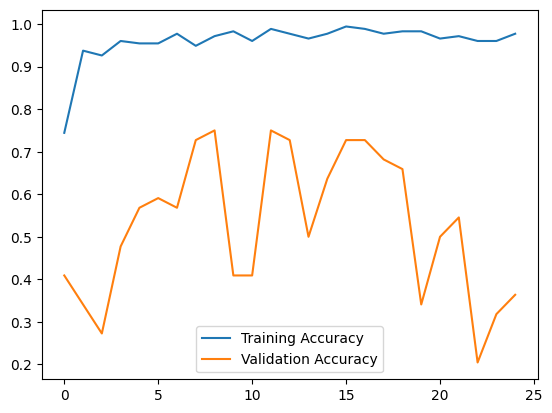

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# ===============================
# AUGMENTASI DATA
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# ===============================
# LOAD DATASET (Pastikan Path Benar!)
# ===============================
dataset_path = "/content/rupiah-real-fake-dataset/dataset/dataset"  # Perbaiki path

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Untuk multi-class
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# ===============================
# TRANSFER LEARNING MOBILE NET V2
# ===============================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True  # Freeze layer

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pengganti Flatten
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 kelas
])

# ===============================
# KOMPILE MODEL
# ===============================
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# ===============================
# TRAIN MODEL
# ===============================
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

# ===============================
# SIMPAN MODEL
# ===============================
model.save("model_uang.keras")

# ===============================
# TES MODEL
# ===============================
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [22]:
print(train_generator.class_indices)  # Lihat indeks label


{'uang100asli': 0, 'uang100palsu': 1, 'uang50asli': 2, 'uang50palsu': 3}


In [11]:
import os
train_dir = "/content/rupiah-real-fake-dataset"
val_dir = "/content/rupiah-real-fake-dataset"

print("Kelas di Training Set:")
print(os.listdir(train_dir))  # Harus ada ['asli', 'palsu']

print("Kelas di Validation Set:")
print(os.listdir(val_dir))  # Harus ada ['asli', 'palsu']

Kelas di Training Set:
['dataset']
Kelas di Validation Set:
['dataset']


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
